# Persistence Diagram Covariance Analysis

This notebook performs a covariance analysis for a time series of persistence diagrams. The persistence plane is partitioned into various regions, each of which is served to provide a random variable given by the count of the number of persistence points in that region. The time series of counts are then run through a covariance analysis to determine the covariance decay with respect to the lag.

In [1]:
import numpy as np
import scipy
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
import math, time
import seaborn.apionly as sns 

import sys

%matplotlib inline  

## User-defined variables

In [25]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow/'
sPD_pattern = 'pd_sub/%06d.csv'
data_range = range(1,1500 + 1) # Images to loop through
region_range = range(25, 51) # Regions on the persistence plane to loop through
covariance_windows = range(1, 500 + 1) # Windows for computing covariance decays
noise_level = 50 # Minimum death time for persistence points
max_level = 235 # The value to consider to be the "top" of the persistence plane, on average
dim = 0


## Load the data

In [26]:
region_counts = np.zeros((len(region_range), len(data_range), 4))

for i in data_range:
    
    print i
    
    data = pd.read_csv(sDir+(sPD_pattern % i))
    data = data.loc[data['dim']==dim]
    for region in region_range:
        
        region_key_x = region
        region_key_y = max_level - region
        
        top_left = len(data.loc[(data['birth'] <= region_key_x) & (data['death'] >= region_key_y) ])
        top = len(data.loc[(data['birth'] > region_key_x) & (data['death'] >= region_key_y) ])
        left = len(data.loc[(data['birth'] <= region_key_x) & (data['death'] < region_key_y) & (data['death'] >= noise_level) ])
        center = len(data.loc[(data['birth'] > region_key_x) & (data['death'] < region_key_y) & (data['death'] >= noise_level) ])
        
        region_counts[region-min(region_range), i-min(data_range)] = [top_left, top, left, center]
        
print region_counts

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Compute the covariances

In [30]:
covariances = np.zeros((len(covariance_windows), len(region_range), 4))

for window in covariance_windows:
    base_counts = region_counts[:, 0:(len(data_range) - window), :]
    base_counts_normalized = (base_counts - np.mean(base_counts))
#     base_counts_normalized = base_counts
    shifted_counts = region_counts[:, window:len(data_range), :]
    shifted_counts_normalized = (shifted_counts - np.mean(shifted_counts))
#     shifted_counts_normalized = shifted_counts
    for region_idx in range(0,len(region_range)):
        for i in range(0,4):
            covariances[(window - min(covariance_windows)), region_idx, i] = np.cov(np.vstack((base_counts_normalized[region_idx, :, i], shifted_counts_normalized[region_idx, :, i])))[0,1]

## Plot the time series data

/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()


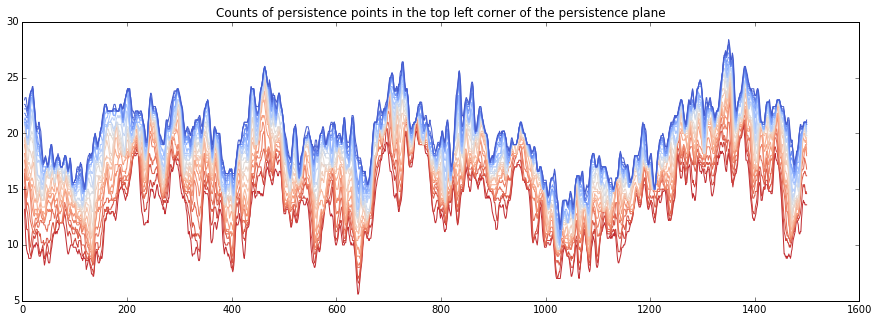

In [31]:

num_lines = len(region_range)

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))

plt.title('Counts of persistence points in the top left corner of the persistence plane')
for i in range(0,num_lines):
    plt.plot(pd.rolling_mean(pd.DataFrame(region_counts[i,:,0]),5))

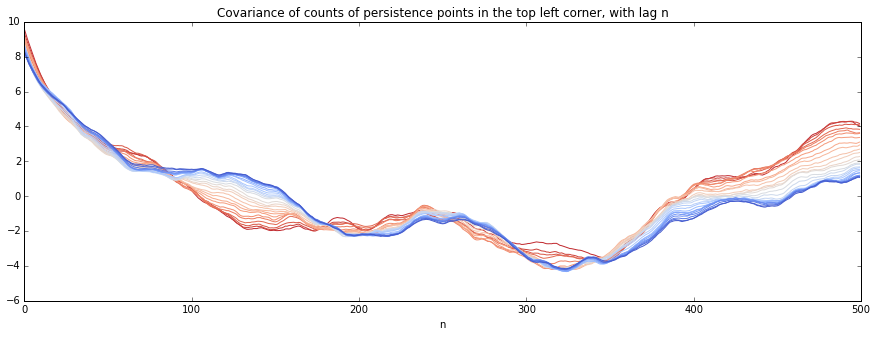

In [32]:

plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_color_cycle(sns.color_palette("coolwarm_r",num_lines))

plt.title('Covariance of counts of persistence points in the top left corner, with lag n')
plt.xlabel('n')
for i in range(0,num_lines):
    plt.plot(covariances[:,i,0])